In [152]:
from glob import glob
from os import chdir
from os.path import basename

import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc
from pqdm.processes import pqdm

chdir('/home/vladimirnoz/ibis')
g2a = 'CAMTA1	LEUTX\tMYF6	PRDM13	SALL3	USF3	ZBED2	ZBED5	ZNF20	ZNF251	ZNF367	ZNF395	ZNF493	ZNF518B	ZNF648'
g2a = set(g2a.split('\t'))
HITS_THR = 10

In [145]:
def get_triple_name(triple):
    tf, matrix_name, team = triple
    return '@'.join(triple)

def get_curve_path(triple):
    tf, matrix_name, team = triple
    return f'curves/{tf}@{matrix_name}@{team}.png'

def get_concordance(row, thr):
     motif_ref, motif_alt = row['ref_motif_pval'], row['alt_motif_pval']
     motif_fc = row['motif_fc']
     as_ref, as_alt = -np.log10(row['ref_comb_pval']), -np.log10(row['alt_comb_pval'])
     as_fc = (as_alt - as_ref) / np.log10(2)
     hit = min(motif_ref, motif_alt) < thr
     if not hit:
         return 'No Hit'
     elif as_fc * motif_fc > 0:
         return 'Concordant'
     else:
          return 'Discordant'

def get_auc(df, triple=None):
    #thresholds = np.linspace(df[['ref_motif_pval', 'alt_motif_pval']].min().min(), df[['ref_motif_pval', 'alt_motif_pval']].max().max(), num=100)[::-1]
    min_v = df[['ref_motif_pval', 'alt_motif_pval']].min().min()
    max_v = df[['ref_motif_pval', 'alt_motif_pval']].max().max()
    thresholds = 10 ** np.linspace(np.log10(min_v), np.log10(max_v), num=100)
    thresholds = sorted(df[['ref_motif_pval', 'alt_motif_pval']].max(axis=1))
    rows = []
    for thr in thresholds:
        mini_df = df.copy()
        mini_df['motif_conc'] = mini_df.apply(lambda x: get_concordance(x, thr), axis=1)
        hits = mini_df.query('motif_conc != "No Hit"').copy()
        if len(hits) == 0:
            continue
        conc = hits.query('motif_conc == "Concordant"')
        rows.append([thr, len(hits), len(conc)/len(hits)])
    data = pd.DataFrame(rows, columns='threshold hits conc_ratio'.split())
    auc_curve = auc(data['hits'], data['conc_ratio'])/max(data['hits'])
    if triple is not None:
        path = get_curve_path(triple)
        fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
        ax.plot(data['hits'], data['conc_ratio'])
        ax.set_xlabel('hits')
        ax.set_ylabel('conc_ratio')
        fig.suptitle('@'.join(triple))
        ax.set_title(f'auc = {auc_curve:.3f}')
        fig.tight_layout()
        plt.savefig(path, bbox_inches='tight')
        plt.close()
    return auc_curve, data


def process_team_and_return_data(triple):
    team, matrix_name, tf = triple
    results = []
    tables = []
    for table in tqdm(glob(f'motif_tables/*@{tf}@{matrix_name}@{team}?.tsv')):
        tables.append(pd.read_table(table).query('fdr_comb_pval < 0.05'))
    df = pd.concat(tables)
    auc_score, data = get_auc(df)
    return data

def process_team(triple):
    team, matrix_name, tf = triple
    results = []
    tables = []
    n = 0
    for table in glob(f'motif_tables/*@{tf}@{matrix_name}@{team}?.tsv'):
        mini_df = pd.read_table(table).query('fdr_comb_pval < 0.05')
        if len(mini_df) == 0:
            continue
        tables.append(mini_df)
        n += len(mini_df)
    if len(tables) == 0:
        return
    df = pd.concat(tables)
    if len(df) < HITS_THR:
        return
    auc_score, data = get_auc(df, triple=triple)
    return [team, matrix_name, tf, auc_score, n]
     
    


In [146]:
def rename_teams(team):
    team_rename_map = {
        'BenchPressers': 'Bench Pressers',
        'BiologyImpostor': 'Biology Impostor',
        'ChatGPT': 'ChatGPTusers',
        'chiCkeNpoxgaNg': 'chiCkeN pox gaNg',
        'NaturalKiller': 'Natural Killer',
        'PostBioinformaticDisorder': 'Post Bioinformatic Disorder',
        'SalimovAndFrolovLaboratory': 'Salimov and Frolov Laboratory',
        'sbitwo': 'sbi two',
        'TheMotifvators': 'The Motifvators',
    }
    if team in team_rename_map:
        return team_rename_map[team]
    return team

teams = glob(f'motif_tables/*@*@*@*.tsv')
teams = sorted(set(tuple(x[:-5].split('@')[-3:][::-1]) for x in teams))
results = list(pqdm(teams, process_team, n_jobs=70))
results = list(filter(lambda x: x is not None, results))
results = pd.DataFrame(results, columns=['team', 'matrix_name', 'tf', 'auc', 'n'])
results['team'] = results['team'].apply(rename_teams)
results['discipline'] = np.where(results['tf'].isin(g2a), 'Discipline.G2A', 'Discipline.A2G')
results_disc = results.copy()

QUEUEING TASKS | :   0%|          | 0/874 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/874 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/874 [00:00<?, ?it/s]

In [147]:
results

,team,matrix_name,tf,auc,n,discipline
0,Bench Pressers,CAMTA1_CHS_CHS,CAMTA1,0.336132,14,Discipline.G2A
1,Bench Pressers,CAMTA1_CHS_GHTS,CAMTA1,0.235942,14,Discipline.G2A
2,Bench Pressers,CAMTA1_GHTS_CHS,CAMTA1,0.471115,14,Discipline.G2A
3,Bench Pressers,CAMTA1_GHTS_GHTS,CAMTA1,0.589831,14,Discipline.G2A
4,Bench Pressers,CREB3L3_C1,CREB3L3,0.467143,10,Discipline.A2G
...,...,...,...,...,...,...
730,sbi two,ZNF780Bmotif3,ZNF780B,0.444686,28,Discipline.A2G
731,sbi two,ZNF831motif0,ZNF831,0.604162,69,Discipline.A2G
732,sbi two,ZNF831motif1,ZNF831,0.473627,69,Discipline.A2G
733,sbi two,ZNF831motif2,ZNF831,0.380900,69,Discipline.A2G


In [148]:
results_disc[results_disc['auc'] == results_disc['auc'].max()]

,team,matrix_name,tf,auc,n,discipline
166,Biology Impostor,3_my_algo0,CREB3L3,0.895,10,Discipline.A2G


In [150]:
results_disc.to_csv('tables/pwm_auc.tsv', sep='\t', index=False)

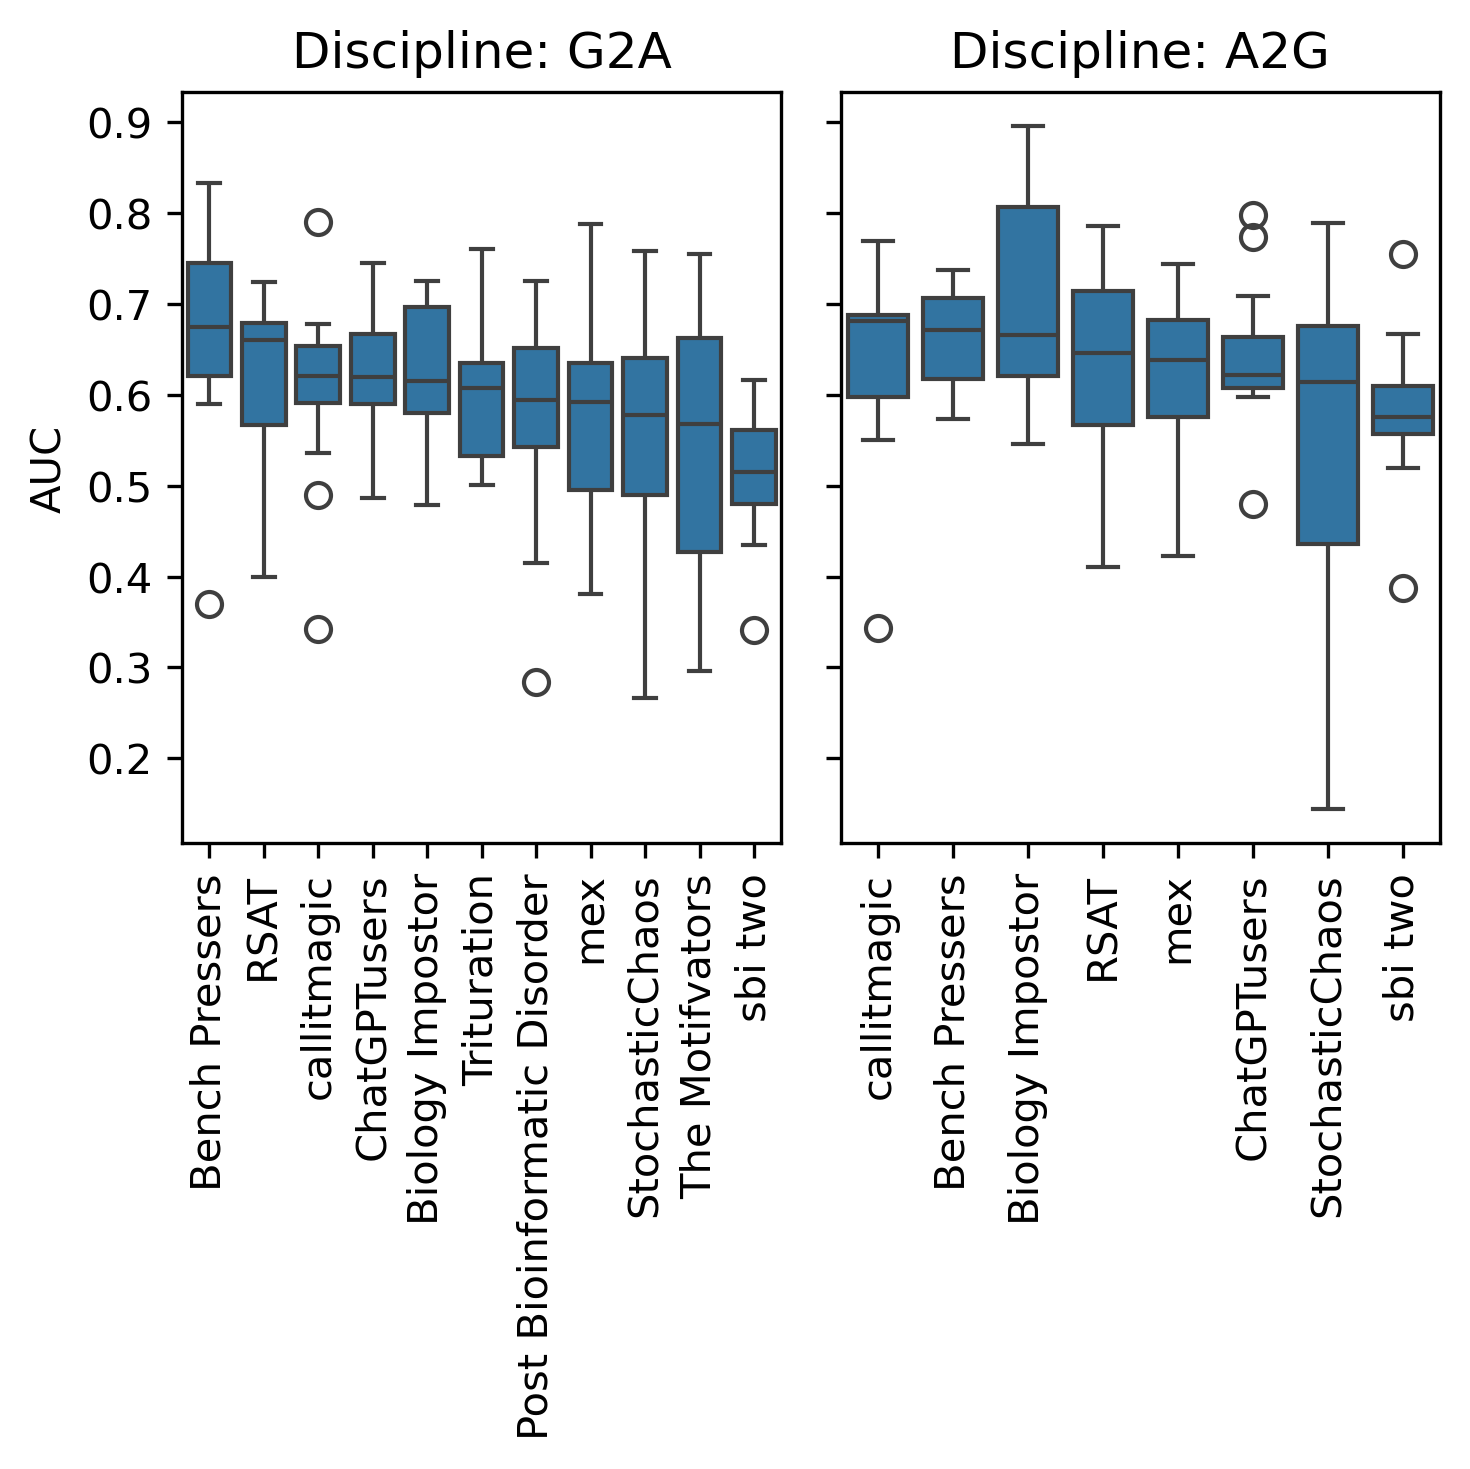

In [151]:
fig, axs = plt.subplots(1, 2, figsize=(5, 5), dpi=300, sharey=True)

maxs = results_disc.groupby(['team', 'tf', 'discipline'])[['auc']].max().reset_index()
medians = maxs.groupby(['team', 'discipline'])['auc'].median().reset_index()

for ax, dis in zip(axs, maxs['discipline'].unique()):
    query = f'discipline == "{dis}"'
    mini_df = maxs.query(query)
    order = medians.query(query).sort_values('auc', ascending=False)['team']
    sns.boxplot(data=mini_df, x='team', y='auc', ax=ax, order=order)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(order, rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel('AUC')
    ax.set_title(dis.replace('.', ': '))
fig.tight_layout()
plt.savefig('figures/auc_box.png', bbox_inches='tight')